#### Note: Transfer learnning is used to recognizing the faces, VGG model has been coosen in this project.
: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


#### Import All the nessary library

In [60]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import zipfile
import itertools
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms  # Ensure to use updated transforms if needed

from torch.optim.lr_scheduler import StepLR  # Only import StepLR from its specific module

# If using torch v2 and new torchvision transforms
from torchvision.transforms.v2 import Compose, Resize, CenterCrop, ToTensor, Normalize, ToImage, ToDtype



#### Import Tranning and validation image and unzzipping it.

In [61]:
TRAIN_FILE= 'train.zip'
TEST_FILE='test.zip'

In [29]:
print("unzipping train set")
with zipfile.ZipFile(TRAIN_FILE, 'r') as zip_ref:
    zip_ref.extractall("train_set")                ## unziping train.zip into folder train_set

print("unzipping test set")
with zipfile.ZipFile(TEST_FILE, 'r') as zip_ref:
    zip_ref.extractall("test_set")                 ## unziping test.zip into folder test_set

unzipping train set
unzipping test set


#### Transform the P1 and P2 collumn in "train_relationships.csv" and "sample_submission.csv" into a image path

In [62]:
train_relationships_df = pd.read_csv("train_relationships.csv")
train_relationships_df['related'] = 1
# Replace / with \ in the 'p1' and 'p2' columns
train_relationships_df['p1'] = train_relationships_df['p1'].str.replace('/', '\\')
train_relationships_df['p2'] = train_relationships_df['p2'].str.replace('/', '\\')
train_relationships_df.head()

,p1,p2,related
0,F0002\MID1,F0002\MID3,1
1,F0002\MID2,F0002\MID3,1
2,F0005\MID1,F0005\MID2,1
3,F0005\MID3,F0005\MID2,1
4,F0009\MID1,F0009\MID4,1


In [88]:
test_df = pd.read_csv("sample_submission.csv")
image_dir = 'test_set/'

# Split the 'img_pair' column into two separate columns using '-' as the delimiter
test_df[['p1', 'p2']] = test_df['img_pair'].str.split('-', expand=True)
test_df = test_df.drop(columns=['img_pair'])
test_df = test_df[['p1', 'p2', 'is_related']]

#apply image full paths
test_df['p1'] = test_df['p1'].apply(lambda x: os.path.join(image_dir, x))
test_df['p2'] = test_df['p2'].apply(lambda x: os.path.join(image_dir, x))

# Now df has full paths for 'p1' and 'p2'
print(test_df.head())


                       p1                      p2  is_related
0  test_set/face05508.jpg  test_set/face01210.jpg           0
1  test_set/face05750.jpg  test_set/face00898.jpg           0
2  test_set/face05820.jpg  test_set/face03938.jpg           0
3  test_set/face02104.jpg  test_set/face01172.jpg           0
4  test_set/face02428.jpg  test_set/face05611.jpg           0


In [84]:
#print the number of rows in train_relationships_df
print(len(train_relationships_df))

3598


In [65]:
def findCustomImages(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            images.append(os.path.join(dirname, filename))
    
    return images

def getAllFolders(path):
    _, F, _ = next(os.walk(path))
    F.sort()
    return F

In [66]:

def addUnrelatedRelations(df, root):
    
    #create empty data-frame for all non-relations
    non_relations = []
    
    #get all families
    F = getAllFolders(root)
    for f in F:
        family_members = getAllFolders(root+f)
        
        #correct format for family members
        family_members = [os.path.join(f, member) for member in family_members]
            
        #check if family-relation already exists, if not add to non_relations list
        for i in range(len(family_members)):
            for j in range(i+1, len(family_members)):
                subset = [family_members[i], family_members[j]]
                if not ((df['p1'] == subset[0]) & (df['p2'] == subset[1])).any() and not ((df['p1'] == subset[1]) & (df['p2'] == subset[0])).any():
                    non_relations.append([subset[0], subset[1], 0])
    
    return pd.DataFrame(non_relations, columns = ['p1', 'p2', 'related'])


In [10]:
non_relations_df = addUnrelatedRelations(train_relationships_df, "train_set\\")

In [11]:
new_df = pd.concat([train_relationships_df, non_relations_df]).sort_values(by=['p1']).reset_index(drop=True)

In [12]:
new_df.head()

,p1,p2,related
0,F0002\MID1,F0002\MID3,1
1,F0002\MID1,F0002\MID2,0
2,F0002\MID2,F0002\MID3,1
3,F0005\MID1,F0005\MID2,1
4,F0005\MID1,F0005\MID3,0


In [67]:
root = "train_set\\"

samples = []
for index, instance in new_df.iterrows():
    person1 = root+instance.p1
    person2 = root+instance.p2

    person1_images = findCustomImages(person1)
    person2_images = findCustomImages(person2)
    
    for i in person1_images:
        for j in person2_images:
            sample = []
            sample.append(i)
            sample.append(j)
            sample.append(instance['related'])
            samples.append(sample)

In [68]:
df = pd.DataFrame(samples, columns = ["p1", "p2", "related"])

In [15]:
df.head(15)

,p1,p2,related
0,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00009_face1.jpg,1
1,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00010_face1.jpg,1
2,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00011_face3.jpg,1
3,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00013_face3.jpg,1
4,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00014_face1.jpg,1
5,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00015_face1.jpg,1
6,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00017_face1.jpg,1
7,train_set\F0002\MID1\P00009_face3.jpg,train_set\F0002\MID3\P00018_face2.jpg,1
8,train_set\F0002\MID1\P00010_face4.jpg,train_set\F0002\MID3\P00009_face1.jpg,1
9,train_set\F0002\MID1\P00010_face4.jpg,train_set\F0002\MID3\P00010_face1.jpg,1


In [16]:
print("There are ",df.shape[0]," image pairs existing as a relative")

There are  433539  image pairs existing as a relative


In [17]:
objects = df[['p1', 'p2']].values.tolist()

In [18]:
objects

[['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00009_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00010_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00011_face3.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00013_face3.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00014_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00015_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00017_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00009_face3.jpg',
  'train_set\\F0002\\MID3\\P00018_face2.jpg'],
 ['train_set\\F0002\\MID1\\P00010_face4.jpg',
  'train_set\\F0002\\MID3\\P00009_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00010_face4.jpg',
  'train_set\\F0002\\MID3\\P00010_face1.jpg'],
 ['train_set\\F0002\\MID1\\P00010_face4.jpg',
  'train_set\\F0002\\MID

#### Image transformation and normalization


<img src= "image.png" align = "left" width ="1000">

In [69]:
# Define transforms using v2 API
data_transforms = {
    'train': Compose([
        Resize(255),
        CenterCrop(224),
        ToImage(),               # Ensure image is in PIL format
        ToDtype(torch.float32, scale=True),  # Convert to float and scale to [0, 1]
        #Normalize(mean=[0.485, 0.456, 0.406] * 2, std=[0.229, 0.224, 0.225] * 2)
    ]),
    'val': Compose([
        Resize(255),
        CenterCrop(224),
        ToImage(),               # Ensure image is in PIL format
        ToDtype(torch.float32, scale=True),  # Convert to float and scale to [0, 1]
        #Normalize(mean=[0.485, 0.456, 0.406] * 2, std=[0.229, 0.224, 0.225] * 2)
    ]),
}

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225, 0.229, 0.224, 0.225])

In [23]:

train_df = df
# Extract image paths and labels
train_paths = df[['p1', 'p2']].values
train_labels = df['related'].values

# Create a custom dataset
class FacePairDataset(torch.utils.data.Dataset):
    def __init__(self, image_pairs, labels, transform=None, normalize=None):
        self.image_pairs = image_pairs
        self.labels = labels
        self.transform = transform
        self.normalize = normalize

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.image_pairs[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Concatenate images along the channel dimension
        combined_img = torch.cat((img1, img2), dim=0)
        
        # Apply normalization after concatenation
        if self.normalize:
            combined_img = self.normalize(combined_img)
        
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return combined_img, label

# Create data loader
train_dataset = FacePairDataset(train_paths, train_labels, transform=data_transforms['train'], normalize=normalize)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

#### View the normalize image pair

Normalization Effects:

Normalization involves scaling pixel values to a specific range, often [-1, 1] or [0, 1], and adjusting the mean and standard deviation of the pixel values.
If the normalization parameters (mean and standard deviation) don't match the image data's distribution, the images might appear visually strange because the pixel values are being adjusted in a way that doesn't correspond to the original image’s appearance.
Visual Representation:

When you view a normalized image using matplotlib or similar tools, the values might not map directly to visible colors. For instance, values outside the [0, 1] range might get clipped or misrepresented.

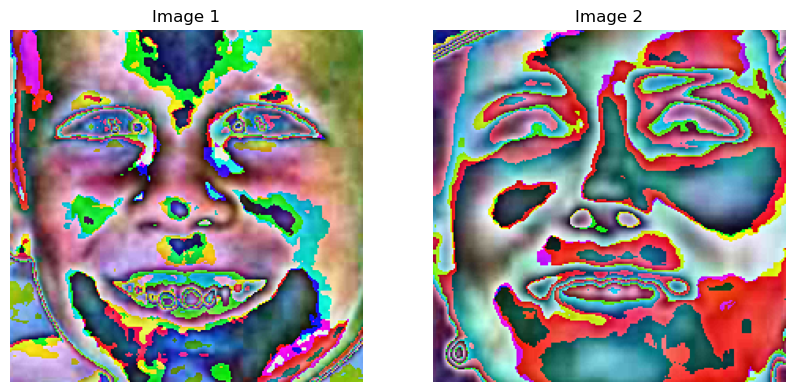

In [24]:
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import ToPILImage

# Get a batch from the data loader
batch = next(iter(train_loader))

# Get the combined image and label
combined_img, label = batch

# Select a single image from the batch
img = combined_img[0]  # Select the first image in the batch

# Split the 6-channel image into two separate images
img1 = img[:3, :, :]  # Select the first 3 channels
img2 = img[3:, :, :]  # Select the last 3 channels

# Convert the tensors to PIL Images
to_pil = ToPILImage()
img1_pil = to_pil(img1)
img2_pil = to_pil(img2)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_pil)
plt.title("Image 1")
plt.axis('off')  # Hide axis
plt.subplot(1, 2, 2)
plt.imshow(img2_pil)
plt.title("Image 2")
plt.axis('off')  # Hide axis
plt.show()


#### Import VGG model and initialize the model.

![alt text](image-3.png)

In [49]:
import torchvision
import torch.nn as nn

# Load the VGG model and modify it
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
model.features[0] = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1)

# Freeze the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Replace the final layer in the classifier
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()



In [50]:
model.classifier[6]

Linear(in_features=4096, out_features=1, bias=True)

BCE stands for Binary Cross-Entropy, which is a common loss function used for binary classification problems.
WithLogits means that this loss function combines the sigmoid activation function with the binary cross-entropy loss in a single step.

<img src= "image-2.png" align = "left" width ="1000">

#### Tranning routine

In [308]:
# Define the loss function and optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

'''
'lr': This is the learning rate, which controls how quickly the model learns from the training data. A higher learning rate can lead to faster convergence, 
but may also cause the model to overshoot the optimal solution. You've specified a learning rate of 1e-4, which is a relatively small value.
'weight_decay': This is a regularization technique that adds a penalty term to the loss function to discourage large weights. 
'''
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([
    #{'params': model.features.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
])
exp_lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training loop
num_epochs =10
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # Squeeze to remove extra dimensions
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        # Convert logits to probabilities
        probs = torch.sigmoid(outputs)

        # Predict class (0 or 1) based on threshold 0.5
        predicted = (probs >= 0.5).float()
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Step the Learning Rate Scheduler
    # function is used to update the learning rate of the optimizer based on the schedule 
    # defined by the learning rate scheduler.
    exp_lr_scheduler.step()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    
    print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')



Epoch 1/10, Loss: 0.4605, Accuracy: 0.7773
Epoch 2/10, Loss: 0.4447, Accuracy: 0.7865
Epoch 3/10, Loss: 0.3730, Accuracy: 0.8288
Epoch 4/10, Loss: 0.3485, Accuracy: 0.8416
Epoch 5/10, Loss: 0.3302, Accuracy: 0.8518
Epoch 6/10, Loss: 0.3263, Accuracy: 0.8543
Epoch 7/10, Loss: 0.3242, Accuracy: 0.8548
Epoch 8/10, Loss: 0.3241, Accuracy: 0.8554
Epoch 9/10, Loss: 0.3235, Accuracy: 0.8561
Epoch 10/10, Loss: 0.3230, Accuracy: 0.8558


#### Save the Model

In [309]:
# Assuming 'model' is your trained model and 'optimizer' is the optimizer used during training

# Save the model state dictionary and optimizer state dictionary
def save_model(model, optimizer, epoch, path="model.pth"):
    torch.save({
        'epoch': epoch,                   # Save the current epoch
        'model_state_dict': model.state_dict(),  # Save the model state dictionary
        'optimizer_state_dict': optimizer.state_dict(),  # Save the optimizer state dictionary
    }, path)
    print(f'Model saved to {path}')

# Example usage after training loop:
save_model(model, optimizer, epoch, path="vgg_model_10_epoch.pth")

Model saved to vgg_model_10_epoch.pth


#### Load the saved Model

In [51]:
# Load the saved model
checkpoint = torch.load("vgg_model_10_epoch.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"Model loaded successfully from epoch {checkpoint['epoch']}")


Model loaded successfully from epoch 10


In [110]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

# Initialize the model with pre-trained weights
model = vgg16(weights=VGG16_Weights.DEFAULT)  # Use VGG16_Weights.DEFAULT for pre-trained weights

# Modify the first convolutional layer to accept 6 channels instead of 3
model.features[0] = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1)

# Modify the classifier to match your number of output classes if needed
model.classifier[6] = nn.Linear(4096, 1)  # Adjust the final layer if needed

# Load the model state dict
checkpoint_path = 'vgg_model_10_epoch.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Test Image prediction

In [114]:

class PredictionDataset(Dataset):
    def __init__(self, validation_df, transform=None):
        self.validation_df = validation_df
        self.transform = transform

    def __len__(self):
        return len(self.validation_df)

    def __getitem__(self, idx):
        img1_path = self.validation_df.iloc[idx]['p1']
        img2_path = self.validation_df.iloc[idx]['p2']
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        combined_img = torch.cat((img1, img2), dim=0)
        return combined_img, img1_path, img2_path

# Assuming `transform` is defined somewhere in your code
# e.g., transform = transforms.Compose([...])

# Load CSV data into DataFrame
validation_df = test_df  # Ensure `df` is the DataFrame with `p1` and `p2`

# Use the appropriate transform from data_transforms
transform = data_transforms['val']  # or 'train' if you are in training mode

# Create the prediction dataset
prediction_dataset = PredictionDataset(validation_df[['p1', 'p2']], transform=transform)
prediction_loader = torch.utils.data.DataLoader(prediction_dataset, batch_size=8, shuffle=False)


In [115]:
print(test_df.head())

                       p1                      p2  is_related
0  test_set/face05508.jpg  test_set/face01210.jpg           0
1  test_set/face05750.jpg  test_set/face00898.jpg           0
2  test_set/face05820.jpg  test_set/face03938.jpg           0
3  test_set/face02104.jpg  test_set/face01172.jpg           0
4  test_set/face02428.jpg  test_set/face05611.jpg           0


In [116]:
predictions = []

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

with torch.no_grad():
    for combined_img, img1_path, img2_path in prediction_loader:
        combined_img = combined_img.to(device)  # Move to GPU if using
        output = model(combined_img)
        predicted_batch = torch.round(torch.sigmoid(output)).cpu().numpy()
        
        # Flatten the batch predictions if necessary
        predictions.extend(predicted_batch.flatten().tolist())
        
        # Print image paths and corresponding predictions
        for p1, p2, pred in zip(img1_path, img2_path, predicted_batch.flatten().tolist()):
            print(f"Image pair: {p1} and {p2} -> Prediction: {pred}")

# Ensure the number of predictions matches the number of rows in test_df
assert len(predictions) == len(test_df), "Number of predictions does not match number of rows in test_df."

# Add predictions to DataFrame
test_df['is_related'] = predictions

# Display the DataFrame with predictions
print(test_df.head())


Image pair: test_set/face05508.jpg and test_set/face01210.jpg -> Prediction: 0.0
Image pair: test_set/face05750.jpg and test_set/face00898.jpg -> Prediction: 1.0
Image pair: test_set/face05820.jpg and test_set/face03938.jpg -> Prediction: 1.0
Image pair: test_set/face02104.jpg and test_set/face01172.jpg -> Prediction: 1.0
Image pair: test_set/face02428.jpg and test_set/face05611.jpg -> Prediction: 1.0
Image pair: test_set/face01219.jpg and test_set/face00274.jpg -> Prediction: 1.0
Image pair: test_set/face04262.jpg and test_set/face00555.jpg -> Prediction: 1.0
Image pair: test_set/face03697.jpg and test_set/face01892.jpg -> Prediction: 1.0
Image pair: test_set/face03524.jpg and test_set/face00319.jpg -> Prediction: 0.0
Image pair: test_set/face03410.jpg and test_set/face05368.jpg -> Prediction: 1.0
Image pair: test_set/face00292.jpg and test_set/face06004.jpg -> Prediction: 1.0
Image pair: test_set/face00353.jpg and test_set/face01203.jpg -> Prediction: 1.0
Image pair: test_set/face031

#### Export the predicted result into "sample_submission.csv"

In [118]:
submission_df = pd.read_csv("sample_submission.csv")
submission_df['is_related'] = predictions

In [119]:
submission_df.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,1.0
3,face02104.jpg-face01172.jpg,1.0
4,face02428.jpg-face05611.jpg,1.0


In [120]:
submission_df.to_csv('submission2.csv', index=False)


<img src= "image-4.png" align = "left" width ="1000">